## 모듈 import

출처: 불균형 데이터 분류  
https://tensorflow.google.cn/tutorials/structured_data/imbalanced_data?hl=ko 

In [1]:
#모듈 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pycaret.classification  import *
from sklearn.tree import DecisionTreeClassifier

# feature selection
import sys, warnings
if not sys.warnoptions: warnings.simplefilter("ignore")
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import cross_val_score
from tqdm import tqdm

#Scailing
from sklearn.preprocessing import PowerTransformer

#Label Encoding
from sklearn.preprocessing import LabelEncoder

In [2]:
#삡운드
import winsound as sd
# 삡싸운드
def beepsound():
    fr = 2000   # range : 37 ~ 32767
    du = 1000 # 1000 ms ==1second
    sd.Beep(fr, du) # winsound.Beep(frequency, duration)

## data 불러오기

In [3]:
# 데이터가 저장된 경로 설정
data_path = '../daplatformers2021/'

# 데이터 불러오기
train = pd.read_csv(data_path + 'trainset.csv')
test = pd.read_csv(data_path + 'testset_final.csv')
submission = pd.read_csv(data_path + 'sample_submission_final.csv')

In [4]:
train = train.drop(columns=['매니저최초가입일', '매니저최초서비스일', '매니저주소'])

### 전처리

In [5]:
data = pd.concat([train,test]).reset_index(drop=True)

- 결측치 채움

In [6]:
### 결측치 제거

# 결측치 0으로 채움
data['청소교육이수여부'] = data['청소교육이수여부'].fillna(0)
data['CS교육이수여부'] = data['CS교육이수여부'].fillna(0)
data['부재중여부'] = data['부재중여부'].fillna(0)
# 결측치 최빈값으로 채움
data['매니저이동방법'] = data['매니저이동방법'].fillna(data['매니저이동방법'].mode()[0])
data['매니저사용휴대폰'] = data['매니저사용휴대폰'].fillna(data['매니저사용휴대폰'].mode()[0])
data['고객가입일'] = data['고객가입일'].fillna(data['고객가입일'].mode()[0]) #데이터 바뀌고 test에 생긴 에러
data['결재형태'] = data['결재형태'].fillna(data['결재형태'].mode()[0]) #데이터 바뀌고 test에 생긴 에러

data['접수시각'] = data['접수시각'].fillna(data['접수시각'].mode()[0])
data['반려동물'] = data['반려동물'].fillna('없음')
# 결측치 판단하여 없음으로 채움
data['우선청소'] = data['우선청소'].fillna('없음')

### 평수 평균 확인 -> 31.xx -> 30평대로 채움
# (10*len(data.query('평수 == "10평대"')) + 20*len(data.query('평수 == "20평대"')) + 
#  30*len(data.query('평수 == "30평대"')) + 40*len(data.query('평수 == "40평대이상"')))/ \
# (len(data.query('평수 == "10평대"'))+len(data.query('평수 == "20평대"'))+
#  len(data.query('평수 == "30평대"'))+len(data.query('평수 == "40평대이상"')))
data['평수'] = data['평수'].fillna('30평대')

In [7]:
#test와 train의 구조를 맞춰줌
data['매니저생년월일'] = data['매니저생년월일'].astype('str').apply(lambda x: x[0:4])
# 새로운 피처 만들기
data['매니저나이'] = data['매니저생년월일'].apply(lambda x: 2021-int(x))
data['매니저나이대'] = data['매니저나이'].apply(lambda x: f'{str(x)[0]}0대')

In [9]:
# 저장해놓기
data_SEQ = data.SEQ
# 인코딩을 위하여 제거 / 이후 나중에 병합함
y_data = data['매칭성공여부']
data = data.drop(columns = ['SEQ','매칭성공여부'])

In [11]:
#라벨인코딩

#범주형변수 수동으로 분리
data[['장기서비스여부','기존고객여부','부재중여부','쿠폰사용여부','매니저성별',
         'CS교육이수여부','청소교육이수여부','부재중서비스가능여부','추천인여부']
     ] = data[['장기서비스여부','기존고객여부','부재중여부','쿠폰사용여부','매니저성별',
         'CS교육이수여부','청소교육이수여부','부재중서비스가능여부','추천인여부'
     ]].astype('str')

# 범주형 변수와 수치형 변수를 분리
cat_features = data.select_dtypes(include=['object']).columns.to_list()
num_features = data.select_dtypes(exclude='object').columns.to_list() 

#수치형변수 scailing
# data[num_features] = PowerTransformer(standardize=True).fit_transform(data[num_features])

#라벨인코딩
#위의 범주형 변수들을 라벨인코딩
for f in cat_features:
    data[f] = LabelEncoder().fit_transform(data[f])

In [12]:
#위에서 떼어놨던 피처 병합
data = pd.concat([data_SEQ, data],axis=1)
data = pd.concat([data, y_data],axis=1)

In [14]:
#train과 test를 분리
train = data.iloc[:23009,:]
test = data.iloc[23009:,:]
test = test.drop(columns = ['매칭성공여부']).reset_index(drop=True)

### DNN in keras

In [ ]:
import tensorflow as tf
from tensorflow import keras

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import os
import tempfile
import matplotlib as mpl
import seaborn as sns
# 검증을 위함
from sklearn.metrics import roc_auc_score

In [ ]:
# 데이터 불균형 평가
neg, pos = np.bincount(train['매칭성공여부'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

In [ ]:
# 데이터 정의
cleaned_df = train.copy()
# You don't want the `Time` column.
cleaned_df.pop('SEQ')

In [ ]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('매칭성공여부'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('매칭성공여부'))
test_labels = np.array(test_df.pop('매칭성공여부'))

#  스케일러 사용
train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [ ]:
scaler = StandardScaler()

# 정규화해줌
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

In [ ]:
# def make_model(metrics=METRICS, output_bias=None):
#     if output_bias is not None:
#         output_bias = tf.keras.initializers.Constant(output_bias)
#     model = keras.Sequential([
#         keras.layers.Dense(256, activation='relu',input_shape=(train_features.shape[-1],)),
#         keras.layers.Dropout(0.5),
#         keras.layers.Dense(128, activation='selu'),
#         keras.layers.Dropout(0.2),
#         keras.layers.BatchNormalization(),
#         keras.layers.Dense(32, activation='relu'),
#         keras.layers.Dropout(0.5),
#         keras.layers.Dense(16, activation='selu'),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias),
#   ])
# val_loss .20

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# 모델의 층을 쌓는 부분
def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(256, activation='relu',input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(128, activation='selu'),
        keras.layers.Dropout(0.2),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(16, activation='selu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias),
  ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)
    
    return model

In [ ]:
EPOCHS = 100
BATCH_SIZE = 32

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

In [ ]:
model = make_model()
model.summary()

In [ ]:
# 초기 가중치 체크 포인트
# 다양한 학습 과정을 비교하려면 이 초기 모델의 가중치를 체크포인트 파일에 보관하고 학습 전에 각 모델에 로드
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [ ]:
# 그래프 그릴때 색등을 지정
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
# loss를 그래프로 그려줌
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train '+label)
    plt.semilogy(history.epoch, history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()

In [ ]:
# 학습이력 확인을 위한 함수
def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
    if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
        plt.ylim([0.8,1])
    else:
        plt.ylim([0,1])

    plt.legend()

In [ ]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

- 오버샘플링

In [ ]:
# 오버샘플링
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [ ]:
# tf.data 사용
BUFFER_SIZE = 100000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [ ]:
for features, label in pos_ds.take(1):
    print("Features:\n", features.numpy())
    print()
    print("Label: ", label.numpy())

In [ ]:
# experimental.sample_from_datasets 를 사용하여 두 가지를 병합
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [ ]:
#이 데이터 세트를 사용하려면 epoch당 스텝 수가 필요
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
# 초기 바이어스 조정
initial_bias = np.log([pos/neg])

In [ ]:
# 오버 샘플링 된 데이터에 대한 학습
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

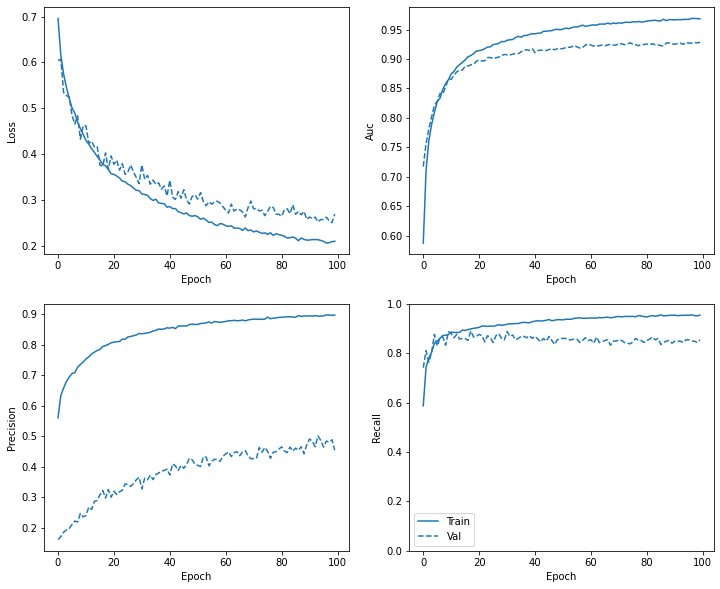

In [37]:
# 교육이력확인
plot_metrics(resampled_history)

In [39]:
# # 재교육 -> 사용하지 않음
# resampled_model = make_model()
# resampled_model.load_weights(initial_weights)

# # Reset the bias to zero, since this dataset is balanced.
# output_layer = resampled_model.layers[-1] 
# output_layer.bias.assign([0])

# resampled_history = resampled_model.fit(
#     resampled_ds,
#     # These are not real epochs
#     steps_per_epoch=30,
#     epochs=10*EPOCHS,
#     callbacks=[early_stopping],
#     validation_data=(val_ds))

In [40]:
# # 재훈련 확인
# plot_metrics(resampled_history)

loss :  0.2707936763763428
tp :  384.0
fp :  464.0
tn :  3680.0
fn :  74.0
accuracy :  0.883094310760498
precision :  0.4528301954269409
recall :  0.8384279608726501
auc :  0.9267091155052185
prc :  0.7374457716941833

Legitimate Transactions Detected (True Negatives):  3680
Legitimate Transactions Incorrectly Detected (False Positives):  464
Fraudulent Transactions Missed (False Negatives):  74
Fraudulent Transactions Detected (True Positives):  384
Total Fraudulent Transactions:  458


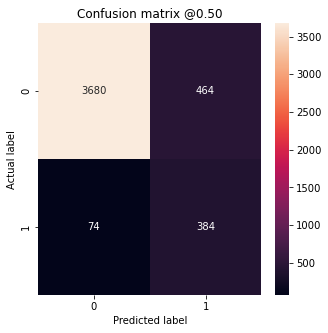

In [38]:
# 메트릭 평가
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

In [39]:
# 검증
roc_auc_score(test_labels, resampled_model.predict(test_features))

0.9295556473504071

In [40]:
# 형식에 맞게 변형
test = np.array(test.drop('SEQ', axis=1))
# 정규화해줌
test = scaler.fit_transform(test)
test = np.clip(test, -5, 5)

In [41]:
pred = resampled_model.predict(test)
submission['pred'] = pred

In [42]:
len(submission.query('pred > 0.5'))

717

In [47]:
beepsound()

### Make submission 

In [43]:
t = pd.Timestamp.now()
fname = f'submission_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv'
# fname = 'submission_나이대_xgb.csv'
submission.to_csv('../submission/'+fname, index=False)
print("'{}' is ready to submit." .format(fname))

'submission_11222359.csv' is ready to submit.


# END